In [7]:
import torch
import numpy as np
from scipy.linalg import sqrtm
import sklearn.datasets
import random
import pandas as pd
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
import scipy
from sklearn.decomposition import PCA

import os, sys
sys.path.append("..")

from distributions import StandardNormalSampler, DatasetSampler
from networks import PICNN
from embeddings import identity_encoder, one_hot_encoder, crime_encoder
from copy import deepcopy
from training import pretrain_parabola, calculate_val_loss
from utils import split_data
from fairness_metrics import compute_KS

In [8]:
# load data
raw_data = scipy.io.loadmat('../datasets/Crime.mat')
S_all= raw_data["Sreal"]
X_all = raw_data["X"]
Y_all = raw_data["Y"]
Y_all.shape

# preprocess data
# dimensionality reduction of X_all with PCA to 10 dimensions (for rf performance worsened by 5%)
pca = PCA(n_components=7)
X_all = pca.fit_transform(X_all)
print("Explained variance PCA X features:", sum(pca.explained_variance_ratio_))

# create a binned version of S_all where the values frequencies which are almost uniform
vals = []
freqs = pd.DataFrame()
for S_val in np.unique(S_all):
    index_val = (S_all == S_val).squeeze()
    # print("instances of s = ", S_val, ":", sum(index_val))
    for _ in range(index_val.sum()):
        vals.append(S_val)
    # add to freqs S_val and count
    freqs[S_val] = [index_val.sum()]

freqs = freqs.T

# find quintiles of vals
quintiles = np.percentile(vals, [20, 40, 60, 80])
print(quintiles)

# select freqs with index less than quintiles
freqs[freqs.index <= quintiles[0]].sum().sum()

S_all_data = pd.DataFrame(S_all)

# add "sensitive" column to S_all, where the values of S_all are mapped to the quintiles
S_all_data['sensitive'] = 0
S_all_data.loc[S_all_data[0] <= quintiles[0], 'sensitive'] = sum(
    np.array(
        freqs[freqs.index <= quintiles[0]]
        ).flatten()*
    np.array(
        freqs.index[freqs.index <= quintiles[0]]
        )/sum(
    np.array(freqs[freqs.index <= quintiles[0]])
        )
    )
S_all_data.loc[(S_all_data[0] > quintiles[0]) & (S_all_data[0] <= quintiles[1]), 'sensitive'] = sum(np.array(
        freqs[(freqs.index > quintiles[0])&(freqs.index <= quintiles[1])]
        ).flatten() * np.array(
        freqs.index[(freqs.index > quintiles[0])&(freqs.index <= quintiles[1])])/sum(np.array(
        freqs[(freqs.index > quintiles[0])&(freqs.index <= quintiles[1])]
        )))
S_all_data.loc[(S_all_data[0] > quintiles[1]) & (S_all_data[0] <= quintiles[2]), 'sensitive'] = sum(
    np.array(
        freqs[(freqs.index > quintiles[1])&(freqs.index <= quintiles[2])]
        ).flatten()*
    np.array(
        freqs.index[(freqs.index > quintiles[1])&(freqs.index <= quintiles[2])]
        )/sum(
    np.array(freqs[(freqs.index > quintiles[1])&(freqs.index <= quintiles[2])])
        )
    )
S_all_data.loc[(S_all_data[0] > quintiles[2]) & (S_all_data[0] <= quintiles[3]), 'sensitive'] =sum(
    np.array(
        freqs[(freqs.index > quintiles[2])&(freqs.index <= quintiles[3])]
        ).flatten()*
    np.array(
        freqs.index[(freqs.index > quintiles[2])&(freqs.index <= quintiles[3])]
        )/sum(
    np.array(freqs[(freqs.index > quintiles[2])&(freqs.index <= quintiles[3])])
        )
    )
S_all_data.loc[S_all_data[0] > quintiles[3], 'sensitive'] = sum(
    np.array(
        freqs[freqs.index > quintiles[3]]
        ).flatten()*
    np.array(
        freqs.index[freqs.index > quintiles[3]]
        )/sum(
    np.array(freqs[freqs.index > quintiles[3]])
        )
    )

S_all_data

# normalize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)


Explained variance PCA X features: 0.809300583589589
[0.01 0.04 0.1  0.31]


/var/folders/xq/xghc3p993rg91s7qn_5yn2w80000gn/T/ipykernel_2077/425774845.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.006801909307875895' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  S_all_data.loc[S_all_data[0] <= quintiles[0], 'sensitive'] = sum(


In [9]:
trial_n = 0
random_state = trial_n

test_OT_size = 0.2
test_models_size = 0.2
ot_valid_size = 0.1

GPU_DEVICE = 0
device = torch.device(f'cuda:{GPU_DEVICE}' if torch.cuda.is_available() else 'cpu')

feature_dim = 32
feature_s_dim = 32
num_layers = 4

D_LR = 1e-3

BATCH_SIZE = 128
MAX_ITER = 2_000
score_freq = 10

LAMBDA = 10
R_LAMBDA = 5

alpha_ridge = 1.0
gamma_RKLS = 0.1
n_estimators = 2
max_depth = 2

OUTPUT_FOLDER = './results/datasets/'
if OUTPUT_FOLDER is not None:
    if not os.path.exists(OUTPUT_FOLDER):
        os.makedirs(OUTPUT_FOLDER)

NAME = None

In [10]:
def pipeline(trial_n, NAME):

    random_state = trial_n
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    print("------------------------------------")
    print("Trial number: ", trial_n)

    X_train_OT, X_test_OT, X_valid_OT, S_train_OT, S_test_OT,S_valid_OT, Y_train_OT, Y_test_OT, X_train_unfair, X_test_unfair, S_train_unfair, S_test_unfair, Y_train_unfair, Y_test_unfair, X_train_fair, X_test_fair, S_train_fair, S_test_fair, Y_train_fair, Y_test_fair = split_data(X_all, S_all_data['sensitive'], Y_all, test_OT_size=test_OT_size, test_models_size=test_models_size, ot_valid_size=ot_valid_size, random_state=random_state)

    # Create an instance of the sampler
    samplers = []
    for S_val in np.unique(S_train_OT): 
        index_val = (S_train_OT == S_val).squeeze()
        print("instances of s = ", S_val, ":", sum(index_val))
        samplers.append(DatasetSampler(X_train_OT.loc[index_val], S_train_OT.loc[index_val], device=device))

    DIM = samplers[0].X_dim
    NUM = len(samplers)
        
    encoder = crime_encoder(NUM, np.unique(S_train_OT))

    D = PICNN(input_x_dim=DIM,input_s_dim=NUM,feature_dim=feature_dim, feature_s_dim=feature_s_dim, out_dim= 1,num_layers=num_layers).to(device)
    print(np.sum([np.prod(list(p.shape)) for p in D.parameters()]), 'parameters in Discriminative Network')

    D.initialize_weights('gaussian',device)

    pretrain_encoder = one_hot_encoder(NUM) 
    pretrain_parabola(D, DIM, NUM, pretrain_encoder, device)

    D_conj = deepcopy(D)

    D_opt = torch.optim.Adam(D.parameters(), lr=D_LR)
    D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=D_LR)

    # initialize validation samplers
    samplers_valid = []
    for S_val in np.unique(S_valid_OT):
        index_val = (S_valid_OT == S_val).squeeze()
        print("instances of s = ", S_val, ":", sum(index_val))
        samplers_valid.append(DatasetSampler(X_valid_OT.loc[index_val], S_valid_OT.loc[index_val], device=device))

    alphas = [1/NUM]*NUM
    proposed_sampler =  StandardNormalSampler(dim=DIM, requires_grad=True, device=device)

    it = 0
    loss_history = []
    loss_validate_history = []
    full_log = {}

    iters = tqdm(range(MAX_ITER))
    for _ in iters:
        it += 1
        D.train(True); D.train(True); 
        loss = 0.

        for n in range(NUM):
            X,S = samplers[n].sample(BATCH_SIZE)
            X = X.to(device)
            X.requires_grad_(True)
            n_enc = encoder.encode(S.flatten())
            n_enc = n_enc.to(device)
            X_inv = D.push(X, n_enc).detach()
            loss += alphas[n] * ((X_inv * X).sum(dim=1).reshape(-1, 1) - D_conj(X_inv, n_enc)).mean()
        log = {'pure_loss' : loss.item()}
        
        # Cycle Loss
        cycle_loss = 0.
        
        for n in range(NUM):
            X,S = samplers[n].sample(BATCH_SIZE)
            X = X.to(device)
            X.requires_grad_(True)
            # Cycle loss
            n_enc = encoder.encode(S.flatten())
            n_enc = n_enc.to(device)
            X_inv = D.push(X,n_enc)
            cycle_loss += alphas[n] * ((D_conj.push(X_inv,n_enc) - X.detach()) ** 2).mean()
        
        loss += LAMBDA * cycle_loss
        
        # Congruence Regularization Loss
        reg_loss = 0.

        Y = torch.cat(
            [proposed_sampler.sample(BATCH_SIZE).detach()] +
            [D.push(samplers[n].sample(BATCH_SIZE)[0].to(device).requires_grad_(True),
                    encoder.encode(samplers[n].sample(BATCH_SIZE)[1].flatten().to(device))
                    ).detach() for n in range(NUM)],
            dim=0
        ).detach()

        for n in range(NUM):
            reg_loss += alphas[n] * D_conj(Y, pretrain_encoder.encode(n*torch.ones(len(Y),device=X.device))) 
        reg_loss -= ((Y ** 2).sum(dim=1) / 2).reshape(-1, 1)
        reg_loss = torch.relu(reg_loss).mean()
        
        loss += R_LAMBDA * reg_loss
        
        # # Positive constraint ! add this after change PICNN
        # loss += LAMBDA_REG_POS * (D.positive_constraint_loss()+D_conj.positive_constraint_loss())
        
        loss_history.append(loss.item())
        loss.backward()
        D_opt.step(); D_conj_opt.step()
        D_opt.zero_grad(); D_conj_opt.zero_grad(); 
        
        # for n in range(benchmark.num):
        #     D_conj.enforce_positive_weights()
        #     D.enforce_positive_weights()

        loss_validate_history.append(calculate_val_loss(D, D_conj, encoder, samplers_valid, 
                                                            proposed_sampler, alphas, LAMBDA, R_LAMBDA, 
                                                            BATCH_SIZE = 10, NUM= NUM, device=device).item())
        
        log = {
            **log,
            'full_loss' : loss.item(),
            'cycle_loss_XYX' : cycle_loss.item(),
            'reg_loss' : reg_loss.item(),
            'loss_validate' : loss_validate_history[-1],
        }        
        iters.set_postfix(loss = loss.item(), loss_validate = loss_validate_history[-1])
        if it % score_freq == 0:
            full_log[it] = log 
            
    plt.plot(loss_history, label='train', color='blue')
    plt.plot(loss_validate_history, label='validate', color='red')
    plt.yscale('log')
    plt.legend()
    plt.show()

    # Transport X_train_fair and X_test_fair
    X_train_fair_transp = D.push(
        torch.tensor(X_train_fair.to_numpy()).float().to(device).requires_grad_(True),
        encoder.encode(torch.tensor(S_train_fair.to_numpy()).float().to(device).flatten())
    ).detach().cpu().numpy()

    X_test_fair_transp = D.push(
        torch.tensor(X_test_fair.to_numpy()).float().to(device).requires_grad_(True),
        encoder.encode(torch.tensor(S_test_fair.to_numpy()).float().to(device).flatten())
    ).detach().cpu().numpy()

    # Ridge regression on unfair data
    ridge_unfair = Ridge(alpha=alpha_ridge)
    ridge_unfair.fit(X_train_fair, Y_train_fair)
    Y_pred_unfair = ridge_unfair.predict(X_test_fair)
    MSE_ridge_unfair = mean_squared_error(Y_test_fair, Y_pred_unfair)
    KS_ridge_unfair = compute_KS(Y_pred_unfair.squeeze(), S_test_fair)
    print("MSE on unfair data:", MSE_ridge_unfair)
    print("KS on unfair data:", KS_ridge_unfair)

    # Ridge regression on fair data
    ridge_fair = Ridge(alpha=alpha_ridge)
    ridge_fair.fit(X_train_fair_transp, Y_train_fair)
    Y_pred_fair = ridge_fair.predict(X_test_fair_transp)
    MSE_ridge_fair = mean_squared_error(Y_test_fair, Y_pred_fair)
    KS_ridge_fair = compute_KS(Y_pred_fair.squeeze(), S_test_fair)
    print("MSE on fair data:", MSE_ridge_fair)
    print("KS on fair data:", KS_ridge_fair)

    # Random forest on unfair data
    rf_unfair = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    rf_unfair.fit(X_train_fair, Y_train_fair.squeeze())
    Y_pred_unfair = rf_unfair.predict(X_test_fair)
    MSE_rf_unfair = mean_squared_error(Y_test_fair, Y_pred_unfair)
    KS_rf_unfair = compute_KS(Y_pred_unfair.squeeze(), S_test_fair)
    print("MSE on unfair data:", MSE_rf_unfair)
    print("KS on unfair data:", KS_rf_unfair)

    # Random forest on fair data
    rf_fair = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth)
    rf_fair.fit(X_train_fair_transp, Y_train_fair.squeeze())
    Y_pred_fair = rf_fair.predict(X_test_fair_transp)
    MSE_rf_fair = mean_squared_error(Y_test_fair, Y_pred_fair)
    KS_rf_fair = compute_KS(Y_pred_fair.squeeze(), S_test_fair)
    print("MSE on fair data:", MSE_rf_fair)
    print("KS on fair data:", KS_rf_fair)

    # KRLS on unfair data
    KRLS_unfair = KernelRidge(kernel='rbf', gamma=gamma_RKLS)
    KRLS_unfair.fit(X_train_fair, Y_train_fair.squeeze())
    Y_pred_unfair = KRLS_unfair.predict(X_test_fair)
    MSE_KRLS_unfair = mean_squared_error(Y_test_fair, Y_pred_unfair)
    KS_KRLS_unfair = compute_KS(Y_pred_unfair.squeeze(), S_test_fair)
    print("MSE on unfair data:", MSE_KRLS_unfair)
    print("KS on unfair data:", KS_KRLS_unfair)

    # KRLS on fair data
    KRLS_fair = KernelRidge(kernel='rbf', gamma=gamma_RKLS)
    KRLS_fair.fit(X_train_fair_transp, Y_train_fair.squeeze())
    Y_pred_fair = KRLS_fair.predict(X_test_fair_transp)
    MSE_KRLS_fair = mean_squared_error(Y_test_fair, Y_pred_fair)
    KS_KRLS_fair = compute_KS(Y_pred_fair.squeeze(), S_test_fair)
    print("MSE on fair data:", mean_squared_error(Y_test_fair, Y_pred_fair))
    print("KS on fair data:", compute_KS(Y_pred_fair.squeeze(), S_test_fair))

    # save log 
    if OUTPUT_FOLDER is not None:
        pd.DataFrame.from_dict(full_log).T.to_csv(os.path.join(OUTPUT_FOLDER, NAME + '.csv'))

    return full_log, MSE_ridge_unfair, KS_ridge_unfair, MSE_ridge_fair, KS_ridge_fair, MSE_rf_unfair, KS_rf_unfair, MSE_rf_fair, KS_rf_fair, MSE_KRLS_unfair, KS_KRLS_unfair, MSE_KRLS_fair, KS_KRLS_fair

------------------------------------
Trial number:  0
length OT train: 1435
length OT test: 399
length unfair train: 319
length unfair test: 80
length fair train: 319
length fair test: 80
length OT valid: 160
instances of s =  0.006801909307875895 : 286
instances of s =  0.026760259179265652 : 339
instances of s =  0.07137195121951219 : 241
instances of s =  0.1862467866323907 : 285
instances of s =  0.6255189873417722 : 284
15950 parameters in Discriminative Network


  6%|▌         | 1211/20000 [00:14<03:37, 86.47it/s, loss=0.0097]


Final Loss: 0.009696089662611485
instances of s =  0.006801909307875895 : 41
instances of s =  0.026760259179265652 : 37
instances of s =  0.07137195121951219 : 27
instances of s =  0.1862467866323907 : 23
instances of s =  0.6255189873417722 : 32


100%|██████████| 2000/2000 [02:53<00:00, 11.53it/s, loss=3.23, loss_validate=3.19]


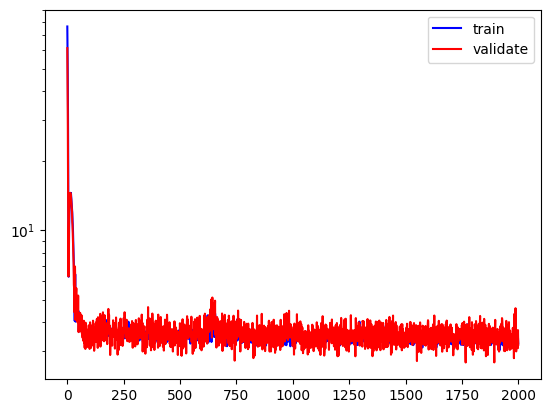

MSE on unfair data: 0.028725942659732884
KS on unfair data: 0.8280701754385965
MSE on fair data: 0.05929722345587757
KS on fair data: 0.35555555555555557
MSE on unfair data: 0.03395992244552141
KS on unfair data: 0.7614035087719299
MSE on fair data: 0.05597291328941274
KS on fair data: 0.5175438596491229
MSE on unfair data: 0.025537947352232183
KS on unfair data: 0.8807017543859649
MSE on fair data: 0.05806352261076233
KS on fair data: 0.28888888888888886
------------------------------------
Trial number:  1
length OT train: 1435
length OT test: 399
length unfair train: 319
length unfair test: 80
length fair train: 319
length fair test: 80
length OT valid: 160
instances of s =  0.006801909307875895 : 302
instances of s =  0.026760259179265652 : 318
instances of s =  0.07137195121951219 : 234
instances of s =  0.1862467866323907 : 285
instances of s =  0.6255189873417722 : 296
15950 parameters in Discriminative Network


  6%|▋         | 1263/20000 [00:14<03:31, 88.48it/s, loss=0.00945]


Final Loss: 0.009448336437344551
instances of s =  0.006801909307875895 : 35
instances of s =  0.026760259179265652 : 39
instances of s =  0.07137195121951219 : 32
instances of s =  0.1862467866323907 : 25
instances of s =  0.6255189873417722 : 29


100%|██████████| 2000/2000 [02:54<00:00, 11.44it/s, loss=3.26, loss_validate=3.35]


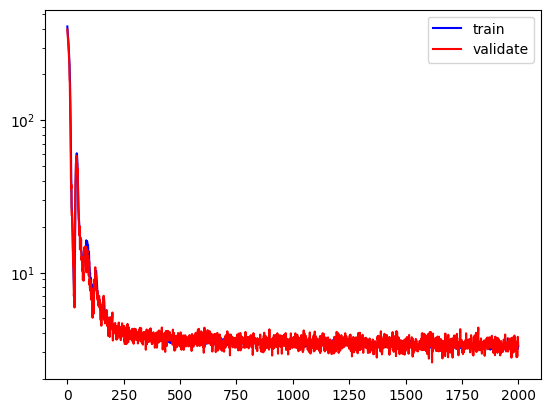

MSE on unfair data: 0.026290242907713656
KS on unfair data: 0.7067307692307693
MSE on fair data: 0.054765322713631624
KS on fair data: 0.425
MSE on unfair data: 0.032981808171864455
KS on unfair data: 0.5817307692307693
MSE on fair data: 0.05631108907856661
KS on fair data: 0.2
MSE on unfair data: 0.038274483457138485
KS on unfair data: 0.7692307692307693
MSE on fair data: 0.058704144577510366
KS on fair data: 0.3261904761904762
------------------------------------
Trial number:  2
length OT train: 1435
length OT test: 399
length unfair train: 319
length unfair test: 80
length fair train: 319
length fair test: 80
length OT valid: 160
instances of s =  0.006801909307875895 : 301
instances of s =  0.026760259179265652 : 326
instances of s =  0.07137195121951219 : 240
instances of s =  0.1862467866323907 : 287
instances of s =  0.6255189873417722 : 281
15950 parameters in Discriminative Network


  7%|▋         | 1359/20000 [00:15<03:30, 88.45it/s, loss=0.0099]


Final Loss: 0.009897391311824322
instances of s =  0.006801909307875895 : 40
instances of s =  0.026760259179265652 : 41
instances of s =  0.07137195121951219 : 27
instances of s =  0.1862467866323907 : 25
instances of s =  0.6255189873417722 : 27


100%|██████████| 2000/2000 [02:53<00:00, 11.54it/s, loss=3.41, loss_validate=3.76]


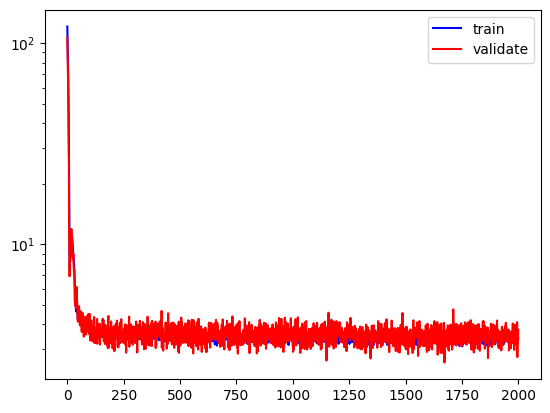

MSE on unfair data: 0.014382680992728759
KS on unfair data: 0.6235294117647059
MSE on fair data: 0.037563597770318494
KS on fair data: 0.3790849673202614
MSE on unfair data: 0.01392761718099598
KS on unfair data: 0.6235294117647059
MSE on fair data: 0.04110288384590381
KS on fair data: 0.49019607843137253
MSE on unfair data: 0.011525568140329267
KS on unfair data: 0.6823529411764706
MSE on fair data: 0.04149162618450295
KS on fair data: 0.4803921568627451
------------------------------------
Trial number:  3
length OT train: 1435
length OT test: 399
length unfair train: 319
length unfair test: 80
length fair train: 319
length fair test: 80
length OT valid: 160
instances of s =  0.006801909307875895 : 314
instances of s =  0.026760259179265652 : 321
instances of s =  0.07137195121951219 : 244
instances of s =  0.1862467866323907 : 276
instances of s =  0.6255189873417722 : 280
15950 parameters in Discriminative Network


  6%|▋         | 1277/20000 [00:14<03:25, 90.91it/s, loss=0.00929]


Final Loss: 0.009290816262364388
instances of s =  0.006801909307875895 : 29
instances of s =  0.026760259179265652 : 48
instances of s =  0.07137195121951219 : 26
instances of s =  0.1862467866323907 : 27
instances of s =  0.6255189873417722 : 30


100%|██████████| 2000/2000 [02:52<00:00, 11.62it/s, loss=3.38, loss_validate=3.22]


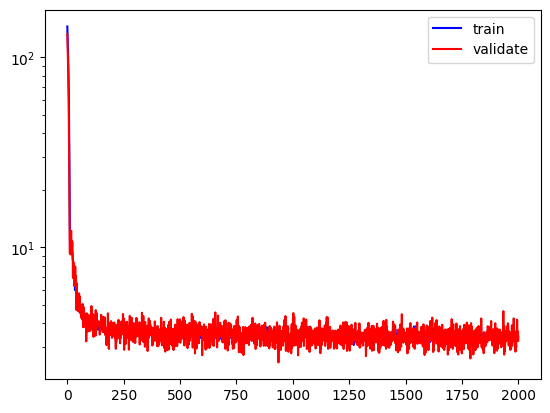

MSE on unfair data: 0.02655822835395081
KS on unfair data: 0.9411764705882353
MSE on fair data: 0.05204807352271418
KS on fair data: 0.2727272727272727
MSE on unfair data: 0.03443477733034728
KS on unfair data: 0.7647058823529411
MSE on fair data: 0.05785242715193858
KS on fair data: 0.29411764705882354
MSE on unfair data: 0.025333964089972506
KS on unfair data: 0.9411764705882353
MSE on fair data: 0.056154614971542206
KS on fair data: 0.4117647058823529
------------------------------------
Trial number:  4
length OT train: 1435
length OT test: 399
length unfair train: 319
length unfair test: 80
length fair train: 319
length fair test: 80
length OT valid: 160
instances of s =  0.006801909307875895 : 302
instances of s =  0.026760259179265652 : 314
instances of s =  0.07137195121951219 : 238
instances of s =  0.1862467866323907 : 275
instances of s =  0.6255189873417722 : 306
15950 parameters in Discriminative Network


  7%|▋         | 1377/20000 [00:15<03:27, 89.60it/s, loss=0.00967]


Final Loss: 0.009666160680353642
instances of s =  0.006801909307875895 : 36
instances of s =  0.026760259179265652 : 40
instances of s =  0.07137195121951219 : 27
instances of s =  0.1862467866323907 : 32
instances of s =  0.6255189873417722 : 25


 30%|██▉       | 594/2000 [00:52<02:04, 11.32it/s, loss=3.4, loss_validate=3.32] 


KeyboardInterrupt: 

In [11]:
tot_trails = 20

list_logs = []
list_MSE_ridge_unfair = []
list_KS_ridge_unfair = []
list_MSE_ridge_fair = []
list_KS_ridge_fair = []
list_MSE_rf_unfair = []
list_KS_rf_unfair = []
list_MSE_rf_fair = []
list_KS_rf_fair = []
list_MSE_KRLS_unfair = []
list_KS_KRLS_unfair = []
list_MSE_KRLS_fair = []
list_KS_KRLS_fair = []

for trial_n in range(tot_trails):
    NAME = 'CRIME_trial_' + str(trial_n)
    log, MSE_ridge_unfair, KS_ridge_unfair, MSE_ridge_fair, KS_ridge_fair, MSE_rf_unfair, KS_rf_unfair, MSE_rf_fair, KS_rf_fair, MSE_KRLS_unfair, KS_KRLS_unfair, MSE_KRLS_fair, KS_KRLS_fair = pipeline(trial_n, NAME)
    list_logs.append(log)
    list_MSE_ridge_unfair.append(MSE_ridge_unfair)
    list_KS_ridge_unfair.append(KS_ridge_unfair)
    list_MSE_ridge_fair.append(MSE_ridge_fair)
    list_KS_ridge_fair.append(KS_ridge_fair)
    list_MSE_rf_unfair.append(MSE_rf_unfair)
    list_KS_rf_unfair.append(KS_rf_unfair)
    list_MSE_rf_fair.append(MSE_rf_fair)
    list_KS_rf_fair.append(KS_rf_fair)
    list_MSE_KRLS_unfair.append(MSE_KRLS_unfair)
    list_KS_KRLS_unfair.append(KS_KRLS_unfair)
    list_MSE_KRLS_fair.append(MSE_KRLS_fair)
    list_KS_KRLS_fair.append(KS_KRLS_fair)

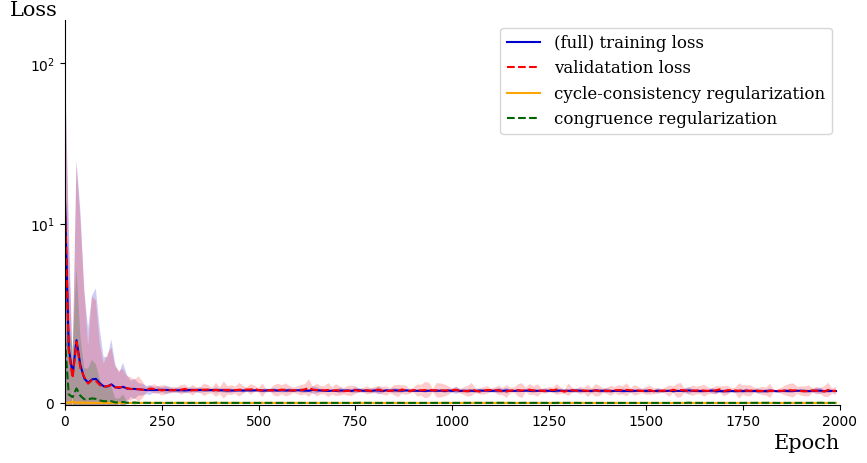

In [12]:
# PLOT LOSSES from log
mean_full_loss = 0.
mean_cycle_loss = 0.
mean_reg_loss = 0.
mean_loss_validate = 0.

for log in list_logs:
    mean_full_loss += np.array([log[i]['full_loss'] for i in log])/tot_trails
    mean_cycle_loss += np.array([log[i]['cycle_loss_XYX'] for i in log])/tot_trails
    mean_reg_loss += np.array([log[i]['reg_loss'] for i in log])/tot_trails
    mean_loss_validate += np.array([log[i]['loss_validate'] for i in log])/tot_trails

std_full_loss = np.std([np.array([log[i]['full_loss'] for i in log]) for log in list_logs], axis=0)
std_cycle_loss = np.std([np.array([log[i]['cycle_loss_XYX'] for i in log]) for log in list_logs], axis=0)
std_reg_loss = np.std([np.array([log[i]['reg_loss'] for i in log]) for log in list_logs], axis=0)
std_loss_validate = np.std([np.array([log[i]['loss_validate'] for i in log]) for log in list_logs], axis=0)

# plot mean and faded stds
plt.figure(figsize=(10, 5))
plt.plot(mean_full_loss, label='(full) training loss', color='mediumblue')
plt.fill_between(range(len(mean_full_loss)), mean_full_loss - std_full_loss, mean_full_loss + std_full_loss, alpha=0.2, color='mediumblue', edgecolor=None)
plt.plot(mean_loss_validate, label='validatation loss', color='red', linestyle='--')
plt.fill_between(range(len(mean_full_loss)), mean_loss_validate - std_loss_validate, mean_loss_validate + std_loss_validate, alpha=0.2, color='red', edgecolor=None)
plt.plot(mean_cycle_loss, label='cycle-consistency regularization', color='orange')
plt.fill_between(range(len(mean_full_loss)), mean_cycle_loss - std_cycle_loss, mean_cycle_loss + std_cycle_loss, alpha=0.2, color='orange', edgecolor=None)
plt.plot(mean_reg_loss, label='congruence regularization', color='darkgreen',linestyle='--')
plt.fill_between(range(len(mean_full_loss)), mean_reg_loss - std_reg_loss, mean_reg_loss + std_reg_loss, alpha=0.2, color='darkgreen', edgecolor=None)
plt.yscale('symlog', linthresh=1e1)
plt.ylim(bottom=-0.1)
plt.ylabel('Loss',fontdict={'fontfamily': 'serif', 'weight': 10, 'size': 15}, loc='top', rotation=0, labelpad=-20) 
plt.xlabel('Epoch',fontdict={'fontfamily': 'serif', 'weight': 10, 'size': 15}, loc='right', )
# multiply x axis ticks by score_freq
ticks = plt.xticks()[0]
plt.xticks(ticks[1:], [int(tick*score_freq) for tick in ticks[1:]])
plt.xlim(left=0, right=len(mean_full_loss))
plt.legend(prop={'family': 'serif', 'weight': 10, 'size': 12})
# get rid of border on top and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig(OUTPUT_FOLDER + 'CRIME_losses.png')

In [13]:
# Mean and std of MSE and KS
mean_MSE_ridge_unfair = np.mean(list_MSE_ridge_unfair)
std_MSE_ridge_unfair = np.std(list_MSE_ridge_unfair)
mean_KS_ridge_unfair = np.mean(list_KS_ridge_unfair)
std_KS_ridge_unfair = np.std(list_KS_ridge_unfair)

mean_MSE_ridge_fair = np.mean(list_MSE_ridge_fair)
std_MSE_ridge_fair = np.std(list_MSE_ridge_fair)
mean_KS_ridge_fair = np.mean(list_KS_ridge_fair)
std_KS_ridge_fair = np.std(list_KS_ridge_fair)

mean_MSE_rf_unfair = np.mean(list_MSE_rf_unfair)
std_MSE_rf_unfair = np.std(list_MSE_rf_unfair)
mean_KS_rf_unfair = np.mean(list_KS_rf_unfair)
std_KS_rf_unfair = np.std(list_KS_rf_unfair)

mean_MSE_rf_fair = np.mean(list_MSE_rf_fair)
std_MSE_rf_fair = np.std(list_MSE_rf_fair)
mean_KS_rf_fair = np.mean(list_KS_rf_fair)
std_KS_rf_fair = np.std(list_KS_rf_fair)

mean_MSE_KRLS_unfair = np.mean(list_MSE_KRLS_unfair)
std_MSE_KRLS_unfair = np.std(list_MSE_KRLS_unfair)
mean_KS_KRLS_unfair = np.mean(list_KS_KRLS_unfair)
std_KS_KRLS_unfair = np.std(list_KS_KRLS_unfair)

mean_MSE_KRLS_fair = np.mean(list_MSE_KRLS_fair)
std_MSE_KRLS_fair = np.std(list_MSE_KRLS_fair)
mean_KS_KRLS_fair = np.mean(list_KS_KRLS_fair)
std_KS_KRLS_fair = np.std(list_KS_KRLS_fair)

print("Ridge regression on unfair data:")
print(f'MSE: {mean_MSE_ridge_unfair} +- {std_MSE_ridge_unfair}')
print(f'KS: {mean_KS_ridge_unfair} +- {std_KS_ridge_unfair}')

print("Ridge regression on fair data:")
print(f'MSE: {mean_MSE_ridge_fair} +- {std_MSE_ridge_fair}')
print(f'KS: {mean_KS_ridge_fair} +- {std_KS_ridge_fair}')

print("Random forest on unfair data:")
print(f'MSE: {mean_MSE_rf_unfair} +- {std_MSE_rf_unfair}')
print(f'KS: {mean_KS_rf_unfair} +- {std_KS_rf_unfair}')

print("Random forest on fair data:")
print(f'MSE: {mean_MSE_rf_fair} +- {std_MSE_rf_fair}')
print(f'KS: {mean_KS_rf_fair} +- {std_KS_rf_fair}')

print("KRLS on unfair data:")
print(f'MSE: {mean_MSE_KRLS_unfair} +- {std_MSE_KRLS_unfair}')
print(f'KS: {mean_KS_KRLS_unfair} +- {std_KS_KRLS_unfair}')

print("KRLS on fair data:")
print(f'MSE: {mean_MSE_KRLS_fair} +- {std_MSE_KRLS_fair}')
print(f'KS: {mean_KS_KRLS_fair} +- {std_KS_KRLS_fair}')

# save in a csv file
if OUTPUT_FOLDER is not None:
    with open(os.path.join(OUTPUT_FOLDER, 'NLSY_metrics_results.csv'), 'w') as f:
        f.write('MSE_ridge_unfair, std_MSE_ridge_unfair, mean_KS_ridge_unfair, std_KS_ridge_unfair, MSE_ridge_fair, std_MSE_ridge_fair, mean_KS_ridge_fair, std_KS_ridge_fair, MSE_rf_unfair, std_MSE_rf_unfair, mean_KS_rf_unfair, std_KS_rf_unfair, MSE_rf_fair, std_MSE_rf_fair, mean_KS_rf_fair, std_KS_rf_fair, MSE_KRLS_unfair, std_MSE_KRLS_unfair, mean_KS_KRLS_unfair, std_KS_KRLS_unfair, MSE_KRLS_fair, std_MSE_KRLS_fair, mean_KS_KRLS_fair, std_KS_KRLS_fair\n')
        f.write(f'{mean_MSE_ridge_unfair}, {std_MSE_ridge_unfair}, {mean_KS_ridge_unfair}, {std_KS_ridge_unfair}, {mean_MSE_ridge_fair}, {std_MSE_ridge_fair}, {mean_KS_ridge_fair}, {std_KS_ridge_fair}, {mean_MSE_rf_unfair}, {std_MSE_rf_unfair}, {mean_KS_rf_unfair}, {std_KS_rf_unfair}, {mean_MSE_rf_fair}, {std_MSE_rf_fair}, {mean_KS_rf_fair}, {std_KS_rf_fair}, {mean_MSE_KRLS_unfair}, {std_MSE_KRLS_unfair}, {mean_KS_KRLS_unfair}, {std_KS_KRLS_unfair}, {mean_MSE_KRLS_fair}, {std_MSE_KRLS_fair}, {mean_KS_KRLS_fair}, {std_KS_KRLS_fair}\n')

Ridge regression on unfair data:
MSE: 0.023989273728531525 +- 0.005626203062154705
KS: 0.7748767067555768 +- 0.12045230286665139
Ridge regression on fair data:
MSE: 0.05091855436563547 +- 0.008133732255796406
KS: 0.3580919489007724 +- 0.05525159579972777
Random forest on unfair data:
MSE: 0.028826031282182283 +- 0.008617541630260066
KS: 0.6828423930300865 +- 0.0815706289123703
Random forest on fair data:
MSE: 0.05280982834145544 +- 0.006796033499818899
KS: 0.37546439628482975 +- 0.13299904207483915
KRLS on unfair data:
MSE: 0.02516799075991811 +- 0.00946124015100883
KS: 0.81836548384536 +- 0.09985236731443065
KRLS on fair data:
MSE: 0.05360347708607946 +- 0.0070553889282067
KS: 0.3768090569561158 +- 0.07457136288451838
